## DINOv2 Test Notebook

Author: Jackson Guthrie.
Purpose: Classify a form-based long document into various document types using computer vision techniques.

Environment: cv-learning-dev from `environment.yml` in this repo.

Setup

In [1]:
import torch
from transformers import AutoImageProcessor, AutoModel
from datasets import load_dataset
from torchvision.datasets import OxfordIIITPet
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torchvision.transforms as transforms
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

/Users/jackson/anaconda3/envs/cv-learning-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Class to Add Whitespace to the edge of images so we don't have to crop the image or squish it.

In [2]:
class PadToSquare:
    """
    A custom transform to pad a PIL image to a square.
    Preserves the aspect ratio by padding with a fill color.
    """
    def __init__(self, fill_value=0):
        self.fill_value = fill_value

    def __call__(self, img):
        # img is a PIL Image
        width, height = img.size
        if width == height:
            return img
        
        max_dim = max(width, height)
        
        # Create a new image with a square shape and the specified fill color
        new_img = Image.new(img.mode, (max_dim, max_dim), self.fill_value)
        
        # Paste the original image into the center of the new square image
        left = (max_dim - width) // 2
        top = (max_dim - height) // 2
        new_img.paste(img, (left, top))
        
        return new_img

In [3]:
def extract_and_save_attention_maps():
    """
    Downloads the Oxford-IIIT Pet dataset, loads a DINOv2 model,
    and iterates through the images to extract and save their attention maps.
    This version runs entirely on the CPU to ensure stability.
    """
    # 1. Configuration
    MODEL_NAME = "facebook/dinov2-base"
    # NEW: Switched to Oxford-IIIT Pet dataset
    DATASET_ROOT = "./pets_data" 
    OUTPUT_DIR_NUMPY = "pets_attention_maps_numpy" # For raw data
    OUTPUT_DIR_IMAGES = "pets_attention_map_images" # For saved PNGs
    NUM_SAMPLES_TO_PROCESS = 1000
    NUM_SAMPLES_TO_VISUALIZE = 5

    # Create output directories if they don't exist
    if not os.path.exists(OUTPUT_DIR_NUMPY):
        os.makedirs(OUTPUT_DIR_NUMPY)
        print(f"Created numpy output directory: {OUTPUT_DIR_NUMPY}")
    if not os.path.exists(OUTPUT_DIR_IMAGES):
        os.makedirs(OUTPUT_DIR_IMAGES)
        print(f"Created image output directory: {OUTPUT_DIR_IMAGES}")

    # 2. Load Model and Dataset (Force CPU)
    print("Loading DINOv2 model and image processor...")
    
    device = torch.device("cpu")
    print("Forcing CPU usage to ensure stability.")
    
    processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
    model = AutoModel.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    print("Loading Oxford-IIIT Pet dataset...")
    # NEW: Using torchvision.datasets.OxfordIIITPet to load the data.
    # It will be downloaded automatically to the DATASET_ROOT directory if not found.
    dataset = OxfordIIITPet(root=DATASET_ROOT, split='trainval', download=True)
    print("Dataset loaded successfully.")

    # 3. Create a Robust Transformation Pipeline
    transform_pipeline = transforms.Compose([
        PadToSquare(fill_value=128), # Using a neutral gray for padding
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
    ])
    
    visualization_data = []

    # 4. Process Images and Extract Attention
    print(f"Processing {NUM_SAMPLES_TO_PROCESS} images and extracting attention maps...")
    
    for i in tqdm(range(NUM_SAMPLES_TO_PROCESS)):
        try:
            # The dataset returns (image, label)
            image, label = dataset[i]
            
            if image.mode != "RGB":
                image = image.convert("RGB")

            # Get the original filename from the dataset to create a unique and descriptive name
            # Note: Accessing the private '_images' attribute is a common way to get filenames from this dataset
            image_filename = os.path.basename(dataset._images[i])
            base_filename = os.path.splitext(image_filename)[0]

            # Apply the full transformation pipeline
            inputs = transform_pipeline(image).unsqueeze(0).to(device)

            # Attention Extraction
            with torch.no_grad():
                outputs = model(pixel_values=inputs, output_attentions=True)

            attentions = outputs.attentions[-1]
            cls_attention = attentions[0, :, 0, 1:].mean(dim=0)

            patch_count = cls_attention.shape[0]
            w_featmap = h_featmap = int(np.sqrt(patch_count))
            
            if w_featmap * h_featmap != patch_count:
                print(f"Warning: The number of patches ({patch_count}) is not a perfect square. Skipping sample {i}.")
                continue
            
            reshaped_tensor = cls_attention.reshape(w_featmap, h_featmap)
            attention_map = reshaped_tensor.numpy()

            # 5. Save the raw NumPy data and the visualization image
            # Save the raw data as a NumPy array
            numpy_output_filepath = os.path.join(OUTPUT_DIR_NUMPY, f"{base_filename}_attention.npy")
            np.save(numpy_output_filepath, attention_map)
            
            # Save the visual representation as a PNG image
            if plt:
                image_output_filepath = os.path.join(OUTPUT_DIR_IMAGES, f"{base_filename}_attention.png")
                fig_save, ax_save = plt.subplots()
                ax_save.imshow(attention_map, cmap='inferno')
                ax_save.axis('off')
                fig_save.savefig(image_output_filepath, bbox_inches='tight', pad_inches=0)
                plt.close(fig_save) # Close the figure to free memory

            # Store data for final on-screen visualization if needed
            if len(visualization_data) < NUM_SAMPLES_TO_VISUALIZE:
                padded_image = PadToSquare(fill_value=128)(image)
                visualization_data.append({'image': padded_image, 'map': attention_map, 'label': label, 'index': i})


        except Exception as e:
            print(f"\n--- ERROR on Sample {i} ---")
            print(f"Failed during the image transformation step. Error details: {e}")
            break

    print(f"\nExtraction complete. {len(os.listdir(OUTPUT_DIR_NUMPY))} attention maps saved.")

    # 6. On-screen Visualization (Optional)
    if plt and visualization_data:
        print("Visualizing a few examples...")
        fig, axes = plt.subplots(len(visualization_data), 2, figsize=(8, len(visualization_data) * 4))
        fig.suptitle("Original Image vs. DINOv2 Attention Map (CPU)", fontsize=16)

        for idx, data in enumerate(visualization_data):
            # Check if axes is a 1D or 2D array
            if len(visualization_data) > 1:
                ax_img = axes[idx, 0]
                ax_map = axes[idx, 1]
            else:
                ax_img = axes[0]
                ax_map = axes[1]

            ax_img.imshow(data['image'])
            ax_img.set_title(f"Sample {data['index']} (Padded)")
            ax_img.axis('off')

            im = ax_map.imshow(data['map'], cmap='inferno')
            ax_map.set_title(f"Attention Map (Hot = Important)")
            ax_map.axis('off')
            fig.colorbar(im, ax=ax_map)

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading DINOv2 model and image processor...
Forcing CPU usage to ensure stability.
Loading Oxford-IIIT Pet dataset...
Dataset loaded successfully.
Processing 1000 images and extracting attention maps...


100%|██████████| 1000/1000 [01:37<00:00, 10.21it/s]



Extraction complete. 1000 attention maps saved.
Visualizing a few examples...


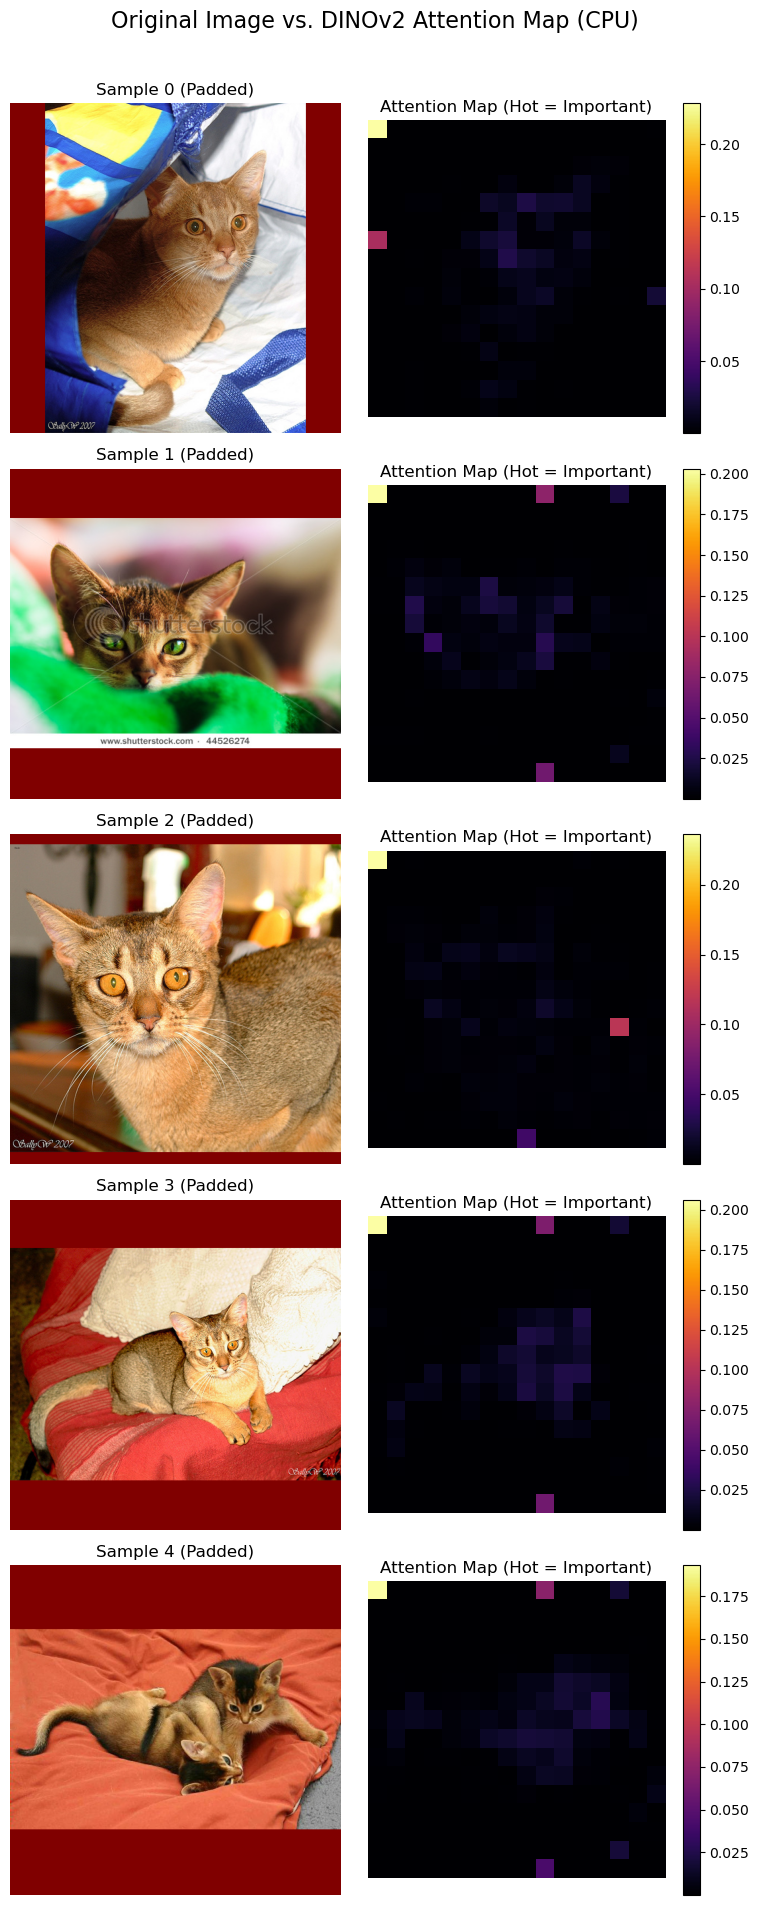

In [4]:
extract_and_save_attention_maps()

Use DBScan to cluster the output attention maps in order to perform un-supervised clustering. We can test the real-world performance on the pet labels inherent in Oxford-IIIT Pet if we want.

In [2]:
# Directory containing saved attention maps
ATTENTION_MAP_DIR = "pets_attention_maps_numpy"

In [3]:
# Load all attention maps and flatten them, removing the top-left pixel
attention_maps = []
filenames = []
for fname in os.listdir(ATTENTION_MAP_DIR):
    if fname.endswith("_attention.npy"):
        arr = np.load(os.path.join(ATTENTION_MAP_DIR, fname))
        # Remove the top-left pixel (position [0, 0])
        arr_no_topleft = np.delete(arr, 0, axis=0)      # Remove first row
        arr_no_topleft = np.delete(arr_no_topleft, 0, axis=1)  # Remove first column
        # Zero out the single most important pixel
        max_idx = np.unravel_index(np.argmax(arr_no_topleft), arr_no_topleft.shape)
        arr_no_topleft[max_idx] = 0
        attention_maps.append(arr_no_topleft.flatten())
        filenames.append(fname)

attention_maps = np.array(attention_maps)
print(f"Loaded {len(attention_maps)} attention maps (top-left pixel removed).")

Loaded 1000 attention maps (top-left pixel removed).


In [4]:
np.set_printoptions(suppress=True, precision=4)
attention_maps

array([[0.0001, 0.0001, 0.0001, ..., 0.    , 0.0005, 0.0006],
       [0.0002, 0.0002, 0.0002, ..., 0.0001, 0.0006, 0.0004],
       [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0005, 0.0003],
       ...,
       [0.0001, 0.0011, 0.0048, ..., 0.0014, 0.0004, 0.0006],
       [0.0002, 0.0018, 0.0063, ..., 0.0007, 0.0009, 0.0004],
       [0.0004, 0.0001, 0.0008, ..., 0.0001, 0.0004, 0.0003]],
      dtype=float32)

In [5]:
# Standardize features for DBSCAN
attention_maps_std = StandardScaler().fit_transform(attention_maps)

# Run DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  # You may need to tune eps/min_samples
labels = dbscan.fit_predict(attention_maps_std)

In [6]:
# Print cluster statistics
unique, counts = np.unique(labels, return_counts=True)
print("Cluster label counts:")
for u, c in zip(unique, counts):
    print(f"Label {u}: {c} samples")

for cluster_id in unique:
    if cluster_id == -1:
        continue  # Skip noise
    idxs = np.where(labels == cluster_id)[0][:3]  # Show up to 3 samples per cluster
    print(f"\nCluster {cluster_id} examples:")
    for idx in idxs:
        arr = np.load(os.path.join(ATTENTION_MAP_DIR, filenames[idx]))
        plt.imshow(arr, cmap='inferno')
        plt.title(f"Cluster {cluster_id} - {filenames[idx]}")
        plt.axis('off')
        plt.show()

Cluster label counts:
Label -1: 1000 samples


#### It looks like the DBScan on the attention masks that come out of DINOv2 are not useful for clustering images together. I removed the top left corner and max value patch, but that did not improve parsimony.

**What if we try KMeans?**

In [8]:
from sklearn.cluster import KMeans

# Standardize features
attention_maps_std = StandardScaler().fit_transform(attention_maps)

# Choose number of clusters (e.g., 37 for Oxford-IIIT Pet breeds, or experiment)
n_clusters = 37
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(attention_maps_std)

# Print cluster statistics
unique, counts = np.unique(labels, return_counts=True)
print("Cluster label counts:")
for u, c in zip(unique, counts):
    print(f"Label {u}: {c} samples")

Cluster label counts:
Label 0: 42 samples
Label 1: 3 samples
Label 2: 2 samples
Label 3: 9 samples
Label 4: 38 samples
Label 5: 1 samples
Label 6: 87 samples
Label 7: 79 samples
Label 8: 89 samples
Label 9: 32 samples
Label 10: 1 samples
Label 11: 6 samples
Label 12: 13 samples
Label 13: 1 samples
Label 14: 59 samples
Label 15: 13 samples
Label 16: 28 samples
Label 17: 88 samples
Label 18: 25 samples
Label 19: 16 samples
Label 20: 42 samples
Label 21: 55 samples
Label 22: 1 samples
Label 23: 20 samples
Label 24: 5 samples
Label 25: 52 samples
Label 26: 27 samples
Label 27: 1 samples
Label 28: 33 samples
Label 29: 38 samples
Label 30: 2 samples
Label 31: 2 samples
Label 32: 35 samples
Label 33: 1 samples
Label 34: 51 samples
Label 35: 1 samples
Label 36: 2 samples


Let's measure cluster purity here.

In [9]:
from collections import Counter

# Get true labels from the Oxford-IIIT Pet dataset
DATASET_ROOT = "./pets_data"
dataset = OxfordIIITPet(root=DATASET_ROOT, split='trainval', download=True)
true_labels = [dataset[i][1] for i in range(len(filenames))]  # Use the same order as filenames

# Compute purity
def cluster_purity(cluster_labels, true_labels):
    total = len(cluster_labels)
    correct = 0
    for cluster in set(cluster_labels):
        indices = [i for i, c in enumerate(cluster_labels) if c == cluster]
        true_in_cluster = [true_labels[i] for i in indices]
        if true_in_cluster:
            most_common = Counter(true_in_cluster).most_common(1)[0][1]
            correct += most_common
    return correct / total

purity = cluster_purity(labels, true_labels)
print(f"Cluster purity: {purity:.4f}")

Cluster purity: 0.1310
